# Brent Oil Prices Time Series Model with xgboost

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import math
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
%matplotlib inline

## Reading dataset

In [2]:
df = pd.read_excel(io='https://www.eia.gov/dnav/pet/hist_xls/RBRTEd.xls', sheet_name='Data 1', skiprows = 2)
df = df.rename({'Europe Brent Spot Price FOB (Dollars per Barrel)': 'Price'}, axis='columns')
df.shape

(8887, 2)

Note the date gaps.

## Drop negative prices if any

In [3]:
indexNames = df[df['Price'] < 0].index
df.drop(indexNames , inplace=True)
df.shape

(8887, 2)

## Filling date gaps

For market closed dates, use the previous date's price.

In [4]:
#make dates the index
df.set_index(pd.DatetimeIndex(df.Date), inplace = True)
#fill date gaps
df = df.resample('D').pad()
#fix the Date column
df.Date = df.index.values
df.reset_index(drop = True, inplace = True)
n_days = df.shape[0]
df.shape

(12788, 2)

In [5]:
df.tail()

,Date,Price
12783,2022-05-19,113.22
12784,2022-05-20,113.63
12785,2022-05-21,113.63
12786,2022-05-22,113.63
12787,2022-05-23,115.13


## Save as csv

In [6]:
df.to_csv('gas.csv', index = False)

## Visualizing the time series dataset

In [7]:
def plot_series(time, series, format = "-", start = 0, end = None):
    plt.plot(time[start:end], series[start:end], format, color="C4")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.grid(True)

Text(0.5, 1.0, 'Brent Oil Price')

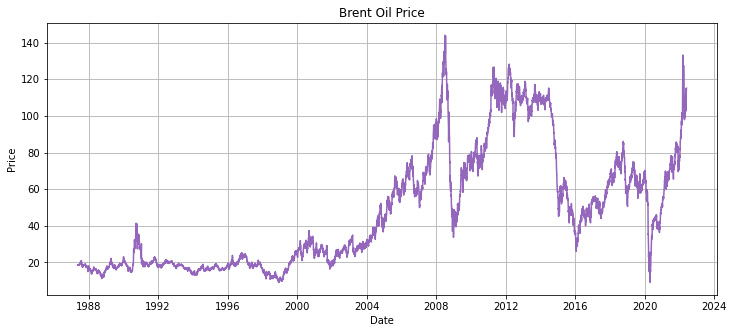

In [8]:
plt.figure(figsize=(12, 5))
plot_series(df['Date'], df['Price'])
plt.title('Brent Oil Price')

## Tuning

In [9]:
n_test = 30

## Functions

In [10]:
# Plot feature importance
from xgboost import plot_importance
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in = 1, n_out = 1, dropnan = True):
    n_vars = 1 if type(data) is list else data.shape[1]

    df = DataFrame(data)

    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))

    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))

    # put it all together
    agg = concat(cols, axis = 1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace = True)

    return agg.values

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test, :], data[-n_test:, :]

# fit an xgboost model and make a one step prediction
def xgboost_forecast_tune(train, testX):
    # transform list into array
    train = asarray(train)
    # split into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]
    # fit model
    model = XGBRegressor(objective = 'reg:squarederror', n_estimators = 500)
    model.fit(trainX, trainy)
    params = { 'max_depth': [2, 4, 6],
           'learning_rate': [0.01, 0.03, 0.05],
           'n_estimators': [200, 400, 600],
           'colsample_bytree': [0.5, 0.7, 0.9]}
    
    #search = GridSearchCV(estimator = model, 
    #               param_grid = params,
    #               scoring = 'neg_mean_squared_error', 
    #               verbose = 1)
    
    search = RandomizedSearchCV(estimator = model, param_distributions = params, 
                                n_iter = 10, cv = 5, scoring = 'neg_mean_squared_error')
                                       
    search.fit(trainX, trainy)       
    
    # make a one-step prediction
    yhat = model.predict(asarray([testX]))
    return yhat[0], model, search

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    tune_results = list()
    for i in range(len(test)):
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        # fit model on history and make a prediction
        yhat, model, search = xgboost_forecast_tune(history, testX)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
        # summarize progress
        print('%d' % i)
        print('Actuarial = %.1f, Predicted = %.1f' % (testy, yhat))
        print("Lowest RMSE: ", math.sqrt(-search.best_score_))
        print("Best parameters:", search.best_params_)
        print("Best estimator across ALL searched parameters:", search.best_estimator_)          
        tune_results.append(search)
        
    # estimate prediction error
    mae = mean_absolute_error(test[:, -1], predictions)

    return mae, test[:, -1], predictions, model, tune_results

## Training the model

In [11]:
# load the dataset
series = read_csv('gas.csv', header = 0, index_col = 0)
values = series.values

In [12]:
# transform the time series data into supervised learning
data = series_to_supervised(values, n_in = 30, n_out = 1)
# evaluate
mae, y, yhat, model, tune_results = walk_forward_validation(data, n_test)
print()
print('MAE: %.3f' % mae)
print('RMAE: %.3f' % math.sqrt(mae))

0
Actuarial = 105.2, Predicted = 105.0
Lowest RMSE:  1.5157035907486718
Best parameters: {'n_estimators': 200, 'max_depth': 2, 'learning_rate': 0.05, 'colsample_bytree': 0.9}
Best estimator across ALL searched parameters: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=2, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=200, n_jobs=16,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)
1
Actuarial = 99.3, Predicted = 103.5
Lowest RMSE:  1.6660873017667293
Best parameters: {'n_estimators': 200, 'max_depth': 2, 'learning_rate': 0.03, 'col

10
Actuarial = 110.5, Predicted = 103.5
Lowest RMSE:  1.6337367208103342
Best parameters: {'n_estimators': 200, 'max_depth': 2, 'learning_rate': 0.03, 'colsample_bytree': 0.5}
Best estimator across ALL searched parameters: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.03, max_delta_step=0,
             max_depth=2, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=200, n_jobs=16,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)
11
Actuarial = 112.1, Predicted = 112.0
Lowest RMSE:  1.5238380999884844
Best parameters: {'n_estimators': 400, 'max_depth': 2, 'learning_rate': 0.03, '

20
Actuarial = 112.1, Predicted = 112.7
Lowest RMSE:  1.3831372752373277
Best parameters: {'n_estimators': 600, 'max_depth': 2, 'learning_rate': 0.01, 'colsample_bytree': 0.9}
Best estimator across ALL searched parameters: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=2, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=600, n_jobs=16,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)
21
Actuarial = 112.1, Predicted = 110.9
Lowest RMSE:  1.397057471437365
Best parameters: {'n_estimators': 400, 'max_depth': 4, 'learning_rate': 0.03, 'c

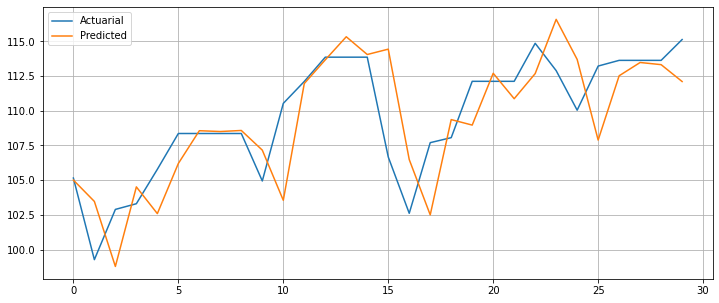

In [13]:
plt.figure(figsize = (12, 5))
plt.plot(y, label = 'Actuarial')
plt.plot(yhat, label = 'Predicted')
plt.grid(True)
plt.legend()
plt.show()